# Debugging OpenCL applications

Debugging OpenCL applications has traditionally been a difficult topic. However there are some tools and techniques to help. These tools are:

* Checking the error codes on every OpenCL call
* Checking memory access from within kernels
* Visual inspection of outputs
* Using **printf** within kernels
* Using **Oclgrind** to check memory access violations

We will introduce an **intentional bug** into our matrix multiplication program and see if we can find it. In this instance we intentionally remove the guard check that protects the kernel from running off the end of buffer **C**. The size of matrices **A**, **B**, and **C** have chosen to be (72,72) with a local size of (4,16). Along dimension 0 an exact number of workgroups (18) can fit into the desired local size of 72. However, along dimension 1 the global size must be increased to 80 in order for an integer number of workgroups to fit. If we do not have a guard in place then array accesses into the matrices will run off the ends, resulting in a memory access violation.

<figure style="margin-left:auto; margin-right:auto; width:80%;">
    <img style="vertical-align:middle" src="../images/matrix_boundaries.svg">
    <figcaption style= "text-align:lower; margin:1em; float:bottom; vertical-align:bottom;">Running off the end of the array due to differences between array size and global size.</figcaption>
</figure>

```C++
// kernels_mat_mult_badmem.c source

// standard matrix multiply kernel 
__kernel void mat_mult (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(0); 
    size_t i1=get_global_id(1); 
    
    // Scratch variable
    float temp=0.0; 

    // Guard mechanism to make sure we do not go
    // outside the boundaries of matrix C
    
    // Comment out the guard mechanism 
    // to make sure we do not go
    // outside the boundaries of matrix C 
    
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
} 
```

## Construct inputs

As before we construct the arrays for input.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

%matplotlib widget

# A is of size (NROWS_C, NCOLS_A)
# B is of size (NCOLS_A, NCOLS_C)    
# C is of size (NROWS_C, NCOLS_C)

NCOLS_A = 72
NROWS_C = 72
NCOLS_C = 72

# Data type
dtype = np.float32

# Make up the arrays A, B, and C
A = np.random.random(size = (NROWS_C, NCOLS_A)).astype(dtype)
B = np.random.random(size = (NCOLS_A, NCOLS_C)).astype(dtype)

# Make up the answer
C = np.matmul(A, B, dtype = dtype)

# Write out the arrays as binary files
A.tofile("array_A.dat")
B.tofile("array_B.dat")

## Run the buggy application

In [6]:
!make clean; make; ./mat_mult_badmem.exe

rm -r *.exe
g++ -std=c++11 -g -O2 -fopenmp -I/usr/local/cuda/include -I../include -L/usr/local/cuda/lib64 mat_mult_badmem.cpp\
	-o mat_mult_badmem.exe -lOpenCL -lomp
In file included from ../include/cl_helper.hpp:10,
                 from mat_mult_badmem.cpp:16:
/usr/local/cuda/include/CL/cl.hpp:5085:28: warning: ignoring attributes on template argument ‘cl_int’ {aka ‘int’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
 5085 |         VECTOR_CLASS<cl_int>* binaryStatus = NULL,
      |                            ^
In file included from mat_mult_badmem.cpp:16:
../include/cl_helper.hpp:16:29: warning: ignoring attributes on template argument ‘cl_int’ {aka ‘int’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
   16 | std::map<cl_int, const char*> error_codes {
      |                             ^
mat_mult_badmem.cpp: In function ‘int main(int, char**)’

Notice that with some OpenCL implementations the code completes without crashing. This is because some OpenCL frameworks (GPU ones in particular) do not have accurate memory access violation checks. Thus small memory access violations result in undefined behaviour. CPU implementations are sensitive memory access violation checks and are more susceptible to memory access bugs than others.

## Visual inspection of outputs

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
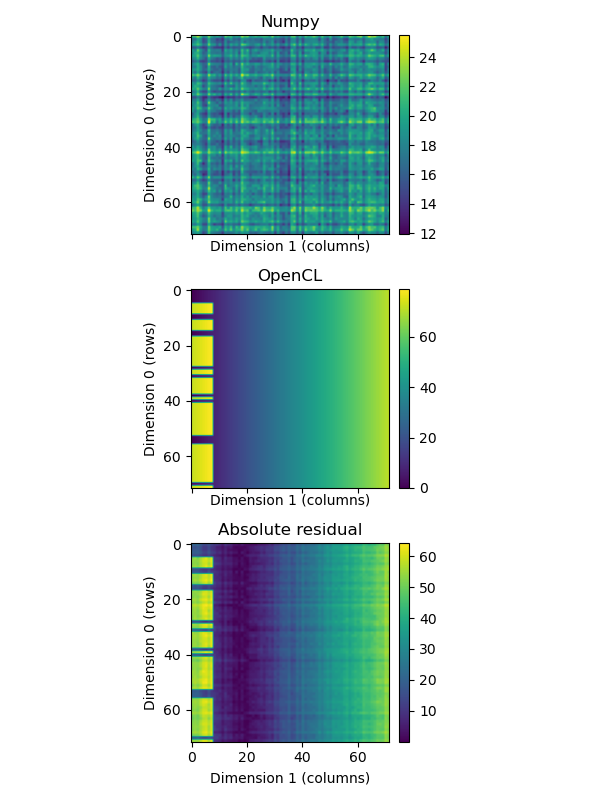

In [5]:
# Import axes machinery
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Read in the output from OpenCL
C_ocl = np.fromfile("array_C.dat", dtype=dtype).reshape((NROWS_C, NCOLS_C))

# Make plots
fig, axes = plt.subplots(3, 1, figsize=(6,8), sharex=True, sharey=True)

# Data to plot
data = [C, C_ocl, np.abs(C-C_ocl)]

# Labels to plot
labels = ["Numpy", "OpenCL", "Absolute residual"]

for n, value in enumerate(data):
    # Plot the graph
    ax = axes[n]
    im = ax.imshow(value)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Set labels on things
    ax.set_xlabel("Dimension 1 (columns)")
    ax.set_ylabel("Dimension 0 (rows)")
    ax.set_title(labels[n])

    # Put a color bar on the plot
    plt.colorbar(mappable=im, cax=cax)

fig.tight_layout()
plt.show()

Running off the end of the array is obvious in this instance because it affects the first 8 cells of next row. That is why 8 cells are affected on the left hand side of the array.

## Checking memory access

When trying to get your OpenCL codes working it is helpful to first make sure that your memory accesses are valid. In this instance we change the kernel to [kernels_mat_mult_memcheck.c](kernels_mat_mult_memcheck.c) so that it fills **C** with a known value. In this case we fill it with **i1**. Run the code and check the results by running the visual check above.

In [4]:
!make; ./mat_mult_memcheck.exe

make: Nothing to be done for 'all'.
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12636 MB
	    max buffer size: 3159 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024


Some lines are filled with higher values of **i1** whereas others are filled with lower values. This shows that one cannot rely on the order in which workgroups complete and the order in which memory adjustments are flushed back to global memory.

## Debugging with **printf**

Some OpenCL implementations, in particular CPU ones, allow the use of a **printf** statement within a kernel. We edit the kernel source in file [kernels_mat_mult_printf.c](kernels_mat_mult_printf.c) to include a printf statement that triggers whenever we exceed the size of the matrices along dimension 1.

```C
// standard matrix multiply kernel 
__kernel void mat_mult (__global float* A, 
                        __global float* B, 
                        __global float* C, 
                        unsigned int N1_A, 
                        unsigned int N0_C,
                        unsigned int N1_C) { 
            
    // C is of size (N0_C, N1_C)
    
    // i0 and i1 represent the coordinates in Matrix C 
    // We assume row-major ordering for the matrices 
    size_t i0=get_global_id(0); 
    size_t i1=get_global_id(1); 
    
    // Scratch variable
    float temp=0.0; 

    // Comment out the guard mechanism 
    // to make sure we do not go
    // outside the boundaries of matrix C
    if (i1>N1_C-1) {
        printf("i1 is %d\n", i1);
    }
    
    //if ((i0<N0_C) && (i1<N1_C)) {
        // Loop over columns of A and rows of B 
        for (size_t n=0; n<N1_A; n++) {
            
            // A is of size (N0_C, N1_A)
            // B is of size (N1_A, N1_C)
            
            // Loop across row i0 of A
            // and down column i1 of B
            temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
        } 
        // Number of rows in C is same as number of rows in A
        C[i0*N1_C+i1]=temp;
    //}
}
```

Now run the program and observe that the workgroups do indeed encounter values of **i1** that go beyond the bounds of the array.

In [20]:
!make; ./mat_mult_printf.exe

g++ -std=c++11 -g -O2 -fopenmp -I/usr/local/cuda/include -I../include -L/usr/local/cuda/lib64 mat_mult_badmem_gdb.cpp\
	-o mat_mult_badmem_gdb.exe -lOpenCL -lomp
In file included from ../include/cl_helper.hpp:10,
                 from mat_mult_badmem_gdb.cpp:16:
/usr/local/cuda/include/CL/cl.hpp:5085:28: warning: ignoring attributes on template argument ‘cl_int’ {aka ‘int’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
 5085 |         VECTOR_CLASS<cl_int>* binaryStatus = NULL,
      |                            ^
In file included from mat_mult_badmem_gdb.cpp:16:
../include/cl_helper.hpp:16:29: warning: ignoring attributes on template argument ‘cl_int’ {aka ‘int’} []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wignored-attributes-Wignored-attributes]8;;]
   16 | std::map<cl_int, const char*> error_codes {
      |                             ^
	               name: NVIDIA GeForce RTX 3060 
	 glo

## Debugging and validation with Oclgrind

[Oclgrind](https://github.com/jrprice/Oclgrind) simulates an OpenCL device and provides tools to check memory access, find data races, and check for erroneous API runtime calls. It currently provides an OpenCL 1.2 interface.


### Memory access checking

In [5]:
!oclgrind ./mat_mult_badmem.exe

	               name: Oclgrind Simulator 
	 global memory size: 134 MB
	    max buffer size: 134 MB
	     max local size: (1024,1024,1024)
	     max work-items: 1024

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult
	Entity: Global(4,72,0) Local(0,8,0) Group(1,4,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !57, !tbaa !47
	At line 32 (column 32) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult
	Entity: Global(5,72,0) Local(1,8,0) Group(1,4,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !57, !tbaa !47
	At line 32 (column 32) of input.cl:
	  temp+=A[i0*N1_A+n]*B[n*N1_C+i1]; 
	

Invalid read of size 4 at global memory address 0x2000000005100
	Kernel: mat_mult
	Entity: Global(6,72,0) Local(2,8,0) Group(1,4,0)
	  %1 = load float, float addrspace(1)* %arrayidx7, align 4, !dbg !57, !tbaa !47
	At line 32 (column 32) of input.cl:
	  

### Interactive debugging

## Vendor-specific tools

### NVIDIA

NVIDIA has 

#### cuda-gdb

#### cuda-memcheck

In [3]:
!/usr/local/cuda/bin/cuda-memcheck ./mat_mult_badmem_gdb.exe

========= CUDA-MEMCHECK
	               name: NVIDIA GeForce RTX 3060 
	 global memory size: 12636 MB
	    max buffer size: 3159 MB
	     max local size: (1024,1024,64)
	     max work-items: 1024
	               name: pthread-AMD Ryzen Threadripper 2950X 16-Core Processor 
	 global memory size: 132854 MB
	    max buffer size: 34359 MB
	     max local size: (4096,4096,4096)
	     max work-items: 4096
	               name: gfx906:sramecc+:xnack- 
	 global memory size: 17163 MB
	    max buffer size: 14588 MB
	     max local size: (1024,1024,1024)
	     max work-items: 256
========= Invalid __global__ read of size 4
=========     at 0x00000de0 in mat_mult
=========     by thread (3,15,0) in block (11,4,0)
=========     Address 0x7fc2f060a31c is out of bounds
=========     Device Frame:mat_mult (mat_mult : 0xde0)
=========     Saved host backtrace up to driver entry point at kernel launch time
=========     Host Frame:/lib64/libnvidia-opencl.so.1 [0x169ed1]
=========     Host Frame:./mat_mu

In [4]:
!cuda-gdb ./mat_mult_badmem.exe

/bin/bash: line 1: cuda-gdb: command not found


### AMD

### INTEL

## Exercise